## Access Maps for Paraguay

- Origins: Population grid (Worldpop downsampled to 500 meters)
- Destinations: Cities, airports, border crossings, and ports

Typical access analysis with two adjustments:
    1. Extract different sets of destinations from OD
    2. Join travel time to origin grid based on "NN with the fastest route" (not necessarily closest NN)

### Load origins and graph

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

In [2]:
# This is a Jupyter Notebook extension which reloads all of the modules whenever you run the code
# This is optional but good if you are modifying and testing source code
%load_ext autoreload
%autoreload 2

In [3]:
# paths to data (copied form DataPreparation script)
iso3 = "PRY"
epsg = 32721
base_out = "/home/wb514197/data/INFRA_SAP"
#base_out = "/home/public/Data/PROJECTS/INFRA_SAP" #r"J:\Data\PROJECTS\INFRA_SAP" GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
#define output data
focal_admin2 = os.path.join(out_folder, "admin.shp")
focal_osm = os.path.join(out_folder, "paraguay-latest.osm.pbf")
wp_1km = os.path.join(out_folder, "WP_2020_1km.tif")
urban_extents = os.path.join(out_folder, "urban_extents.shp")
airports = os.path.join(out_folder, "airports.shp")
ports = os.path.join(out_folder, "ports.shp")
borders = os.path.join(out_folder, "borders.shp")

TODO: Write code to turn **WP_2020_1km.tif** into a point shapefile, for now doing it in ARC :(

In [4]:
pop_file = os.path.join(out_folder, "WP_2020_1km.shp")
G_path = '/home/public/Data/PROJECTS/LAC_GOSTNets/graphs/PRY/G_PRY.pickle'
# global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'

In [5]:
%%time
origins = gpd.read_file(pop_file)

CPU times: user 11.7 s, sys: 583 ms, total: 12.3 s
Wall time: 24.1 s


### Prepare Graph

In [10]:
G = nx.read_gpickle(G_path)

In [11]:
for u, v, data in G.edges(data = True):
    if type(data['Wkt']) == list:
        data['Wkt'] = gn.unbundle_geometry(data['Wkt'])

In [13]:
gn.example_edge(G)

(20, 27155, {'Wkt': 'LINESTRING (-58.9642359 -26.7886577, -58.9640267 -26.7855473, -58.9640437 -26.7853092, -58.9667331 -26.7773011, -58.968865 -26.7709322, -58.9721285 -26.7614295, -58.9767858 -26.7477964, -58.977327 -26.7461269, -58.9777862 -26.7454093, -58.9804101 -26.7425243, -58.9850959 -26.737514, -58.9876421 -26.7347914, -58.9958253 -26.7258862, -59.0029098 -26.7182108, -59.0082559 -26.7125564, -59.0116748 -26.708836)', 'id': 5253, 'infra_type': 'tertiary', 'osm_id': '117752729', 'key': 'edge_5253', 'length': 10.273043637188849, 'Type': 'legitimate'})


In [15]:
all_attr = list(G[20][27155][0].keys())
all_attr

['Wkt', 'id', 'infra_type', 'osm_id', 'key', 'length', 'Type']

In [16]:
attr_list = ['id', 'infra_type', 'osm_id', 'key', 'Type']
attr_list

['id', 'infra_type', 'osm_id', 'key', 'Type']

#### Salt Network

In [18]:
%%time
G_salt = gn.salt_long_lines(G, source='EPSG:4326', target='EPSG:32721', thresh=5000, factor=1000, attr_list=attr_list)

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When m

Identified 2604 unique edge(s) longer than 5000. 
Beginning new node creation...
24840 new edges added and 5208 removed to bring total edges to 47619
9816 new nodes added to bring total nodes to 19117
CPU times: user 9min 20s, sys: 20.7 s, total: 9min 40s
Wall time: 9min 40s


In [19]:
G_time = gn.convert_network_to_time(G_salt, distance_tag = 'length', road_col = 'infra_type', factor = 1000)

In [23]:
gn.save(G_time, "G_PRY_Salt", os.path.join(out_folder, 'graph'))

In [9]:
G_time = nx.read_gpickle(os.path.join(out_folder, 'graph', 'G_PRY_Salt.pickle'))

#### Select largest graph (again)

In [10]:
list_of_subgraphs = [G_time.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G_time), key=len, reverse=True)]

In [11]:
G_largest = list_of_subgraphs[0]

### Prepare destinations

In [12]:
# inAdmin = gpd.read_file(global_admin)
# iso3 = 'URY'
# inA = inAdmin[inAdmin['ISO3166_1_'] == iso3]
# focalCities = inCities[inCities.intersects(inA.unary_union)]
# inCities = gpd.read_file(global_cities)
# dest_cities = inCities[inCities['CNTRY_NAME']=='Uruguay'].assign(dest_type = 'city')

In [13]:
inCities = gpd.read_file(urban_extents)
# inCities = gpd.read_file(cities).set_index("ID").set_geometry(inCities.representative_point())

In [14]:
inCities.head()

,ID,Pop,geometry
0,0,7366.297852,"POLYGON ((-56.52958 -22.09958, -56.51292 -22.0..."
1,2,6080.110352,"POLYGON ((-60.04625 -22.34125, -60.01292 -22.3..."
2,3,89930.921875,"POLYGON ((-55.75458 -22.47458, -55.73792 -22.4..."
3,5,8367.864258,"POLYGON ((-56.54625 -22.94958, -56.52125 -22.9..."
4,7,8470.033203,"POLYGON ((-55.54625 -23.24958, -55.51292 -23.2..."


In [15]:
pop_thresh=50000
inCities = inCities.loc[inCities.Pop>pop_thresh]
inCities['geometry'] = inCities.geometry.centroid
dest_cities = inCities.assign(dest_type = 'city')

In [16]:
len(dest_cities)

8

In [17]:
dest_airports = gpd.read_file(airports)

In [18]:
searchfor = ['Internacional', 'International', 'internacional', 'international' , 'Guarani', 'Silvio']

In [19]:
dest_airports[dest_airports.Name.str.contains('|'.join(searchfor)).fillna(False)]

,OSM_ID,x,y,TYPE,Name,NameEN,TYPE2,geometry
47,161854062,-60.620794,-22.047334,None,Dr. Luis Maria Argaña International Airport,None,None,POINT (-60.62079 -22.04733)
62,168157706,-55.830026,-22.640971,None,Aeropuerto Internacional Dr. Augusto Roberto F...,Dr. Augusto Roberto Fuster International Airport,None,POINT (-55.83003 -22.64097)


See issue with this: https://github.com/worldbank/INFRA_SAP/issues/9

In [20]:
airports_turbo = os.path.join(out_folder, 'airports_turbo.geojson')
dest_airports = gpd.read_file(airports_turbo)

In [21]:
dest_airports['geometry'] = dest_airports.geometry.centroid
dest_airports = dest_airports.assign(dest_type = 'airport')
len(dest_airports)

2

In [22]:
dest_ports = gpd.read_file(ports).assign(dest_type = 'port')
dest_borders = gpd.read_file(borders).assign(dest_type = 'border')
dest_borders['geometry'] = dest_borders.geometry.apply(lambda x: x[0])

In [23]:
dest_all = pd.concat([dest_cities, dest_ports, dest_airports, dest_borders], ignore_index=True)

In [24]:
dest_all.dest_type.value_counts()

port       55
border     24
city        8
airport     2
Name: dest_type, dtype: int64

In [25]:
dest_all.columns

Index(['ID', 'Pop', 'geometry', 'dest_type', 'OSM_ID', 'x', 'y', 'id', '@id',
       'addr:city', 'addr:postcode', 'addr:street', 'aeroway', 'ele', 'iata',
       'icao', 'internet_access', 'name', 'name:en', 'operator', 'type',
       'wikidata', 'wikipedia', 'int_name', 'is_in:city', 'is_in:country',
       'is_in:state', 'CNTRY_NAME', 'NAME', 'ALT1_NAME', 'ALT2_NAME', 'ETYPE',
       'CNTRY_BORD'],
      dtype='object')

In [26]:
dest_all = dest_all[['ID', 'Pop', 'geometry', 'id', 'name', 'NAME', 'dest_type']]

In [27]:
output_path = os.path.join(out_folder,'out')

In [110]:
dest_all.to_csv(os.path.join(output_path, 'destination_all.csv'))

In [28]:
len(origins), len(dest_all)

(508184, 89)

### Snap origins and destinations

#### Snap to origins to 5 nearest nodes

In [31]:
utm = f"EPSG:{epsg}"

In [32]:
%%time
# this function returns a dictionary of origin IDs, with a list of 5 NNs, and a corresponding list of distances
origins_snapped_dict = gn.pandana_snap_to_many(G_largest, origins, source_crs='epsg:4326', target_crs=utm, 
                                               add_dist_to_node_col = True, k_nearest=5, origin_id='pointid')

CPU times: user 1min 18s, sys: 2.05 s, total: 1min 20s
Wall time: 1min 20s


In [33]:
dest_snapped = gn.pandana_snap_c(G_largest, dest_all, source_crs='epsg:4326', target_crs=utm,
                                 add_dist_to_node_col = False)

In [34]:
# origins_unique_nn = list(set(origins_snapped['NN']))
dest_nn = list(dest_snapped['NN'])

In [35]:
list_origins_NN = []
for each in origins_snapped_dict.values():
    list_origins_NN += each['NN']

In [36]:
origins_unique_nn = list(set(list_origins_NN))

In [37]:
len(set(origins_unique_nn))

6117

In [38]:
%%time
curOD = gn.calculate_OD(G_largest, origins_unique_nn, dest_nn, fail_value = 999999999, weight='length')

CPU times: user 8.94 s, sys: 42.8 ms, total: 8.99 s
Wall time: 8.99 s


In [39]:
curOD[curOD==999999999]

array([], dtype=float64)

In [40]:
curOD.shape

(6117, 89)

In [41]:
od_df = pd.DataFrame(curOD, index=origins_unique_nn, columns=dest_nn)

In [42]:
od_df.head()

,new_obj_6434,new_obj_6039,37299,38275_2246_10916,9886,new_obj_3638,new_obj_3113,new_obj_1827,new_obj_6045,33544,...,new_obj_6354,new_obj_6354,new_obj_6121,new_obj_6121,new_obj_6421,new_obj_6421,new_obj_3379,new_obj_3379,new_obj_7079_2595_12225,new_obj_7079_2595_12225
32768,326276.964769,280021.891250,130133.189207,178245.031953,208361.265863,248770.146455,170986.256918,400215.031692,282154.292946,387420.779987,...,307328.765862,307328.765862,267066.554589,267066.554589,324542.557955,324542.557955,253188.720866,253188.720866,9.280484e+05,9.280484e+05
38263_1301_6535,816018.476486,763916.393275,507555.515973,548795.970692,393579.217749,547955.191024,482023.391614,280578.927009,766555.562220,446390.305626,...,833121.593810,833121.593810,756808.066306,756808.066306,814284.069671,814284.069671,554754.560190,554754.560190,1.120158e+06,1.120158e+06
new_obj_6885_1646_8098,631684.833153,418505.501459,656591.747534,701517.901748,542615.449310,840347.144925,671884.870013,886649.872016,421144.670404,962788.899354,...,648787.950477,648787.950477,675419.373575,675419.373575,629950.426339,629950.426339,851063.252140,851063.252140,2.295210e+05,2.295210e+05
new_obj_2769_2415_11535,544164.763866,497909.690348,153572.099304,141944.130383,244798.493597,166549.032583,113556.358196,193166.878140,500042.092044,177347.671145,...,561139.612770,561139.612770,484954.353687,484954.353687,542430.357052,542430.357052,173348.401749,173348.401749,1.014962e+06,1.014962e+06
new_obj_4609,451492.589389,405237.515870,129507.516615,174433.670829,12823.313958,313262.914006,140820.746965,355585.748969,407369.917566,431724.776306,...,468595.706713,468595.706713,392282.179209,392282.179209,449758.182575,449758.182575,323979.021221,323979.021221,7.660197e+05,7.660197e+05


For each origin set of 5 (k) possible NN:
    - Add snapping dist (in time) + time to a destination
    - Which destination? min time from all of them won't necessarily work, so we need to find the closest destination for each origin, and select the NN which yields the fastest travel time to that dest
    - closest_dest.idx should match the OD column order.

In [43]:
%%time
closest_dest = gn.pandana_snap_points(origins, dest_all, source_crs='epsg:4326', target_crs=utm,
                                      add_dist_to_node_col=True)

CPU times: user 26.7 s, sys: 604 ms, total: 27.3 s
Wall time: 27.4 s


In [44]:
closest_dest = closest_dest.set_index('pointid')

In [45]:
closest_dest.head()

,grid_code,geometry,idx,idx_dist
pointid,,,,
1,0.023788,POINT (183778.061 7863739.501),14,223718.408563
2,0.027599,POINT (184654.532 7863754.703),14,222953.988701
3,0.023359,POINT (185530.998 7863769.862),14,222190.381820
4,0.017465,POINT (186407.458 7863784.979),14,221427.596247
5,0.020155,POINT (187283.914 7863800.054),14,220665.640418


In [46]:
# custom_speed = 20 # km/h

In [47]:
%%time
fastest_nn = []
fastest_dist = []

for pointid, items in origins_snapped_dict.items():
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_dist_list = []
    for i in range(0, len(nn_list)):
        dist_snapping = dist_list[i]
#         time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        dist_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
#         time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_dist = dist_snapping+dist_to_dest
#         total_time = time_snapping+time_to_dest
        total_dist_list.append(total_dist)
#         print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")
    min_pos = total_dist_list.index(min(total_dist_list))
    fastest_nn.append(nn_list[min_pos])
    fastest_dist.append(dist_list[min_pos])
#     origins_snapped_smart.loc[pointid, "NN"] = nn_list[min_pos]
#     origins_snapped_smart.loc[pointid, "NN_dist"] = dist_list[min_pos]

CPU times: user 6min, sys: 874 ms, total: 6min 1s
Wall time: 6min 1s


In [48]:
origins_snapped_smart = origins.copy().set_index('pointid')

In [49]:
origins_snapped_smart['NN'] = pd.Series(fastest_nn, index = origins_snapped_smart.index)
origins_snapped_smart['NN_dist'] = pd.Series(fastest_dist, index = origins_snapped_smart.index)

In [50]:
origins_snapped_smart.head()

,grid_code,geometry,NN,NN_dist
pointid,,,,
1,0.023788,POINT (-60.00875 -19.29542),6668_533_2721,72124.911609
2,0.027599,POINT (-60.00042 -19.29542),6668_533_2721,72785.491551
3,0.023359,POINT (-59.99208 -19.29542),6668_533_2721,73450.560639
4,0.017465,POINT (-59.98375 -19.29542),6668_533_2721,74119.997833
5,0.020155,POINT (-59.97542 -19.29542),6668_533_2721,74793.685643


In [51]:
origins_snapped_smart['pointid'] = origins_snapped_smart.index

In [64]:
origins_snapped = origins_snapped_smart.copy()

In [65]:
custom_speed = 20 # km/h
# origins_snapped['NN_dist_seconds'] = ((origins_snapped.NN_dist / 1000) / custom_speed) * 60 * 60
# origins_snapped['NN_dist'] = (origins_snapped.NN_dist / 1000)
origins_snapped['NN_dist_hours'] = ((origins_snapped.NN_dist / 1000) / custom_speed)

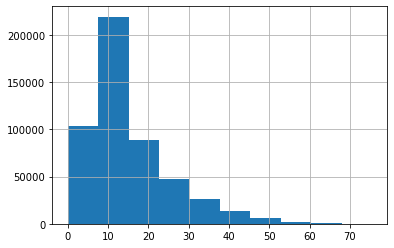

In [67]:
origins_snapped.NN_dist.apply(lambda x: x/1000).hist()

In [54]:
# origins_snapped.NN_dist_hours.hist()

In [68]:
origins_join = origins_snapped.join(od_df, on='NN')

In [69]:
origins_join.head()

,grid_code,geometry,NN,NN_dist,pointid,NN_dist_hours,new_obj_6434,new_obj_6039,37299,38275_2246_10916,...,new_obj_6354,new_obj_6354,new_obj_6121,new_obj_6121,new_obj_6421,new_obj_6421,new_obj_3379,new_obj_3379,new_obj_7079_2595_12225,new_obj_7079_2595_12225
pointid,,,,,,,,,,,,,,,,,,,,,
1,0.023788,POINT (-60.00875 -19.29542),6668_533_2721,72124.911609,1,3.606246,903123.833153,689944.501459,928030.747534,972956.901748,...,920226.950477,920226.950477,946858.373575,946858.373575,901389.426339,901389.426339,1.122502e+06,1.122502e+06,416134.0,416134.0
2,0.027599,POINT (-60.00042 -19.29542),6668_533_2721,72785.491551,2,3.639275,903123.833153,689944.501459,928030.747534,972956.901748,...,920226.950477,920226.950477,946858.373575,946858.373575,901389.426339,901389.426339,1.122502e+06,1.122502e+06,416134.0,416134.0
3,0.023359,POINT (-59.99208 -19.29542),6668_533_2721,73450.560639,3,3.672528,903123.833153,689944.501459,928030.747534,972956.901748,...,920226.950477,920226.950477,946858.373575,946858.373575,901389.426339,901389.426339,1.122502e+06,1.122502e+06,416134.0,416134.0
4,0.017465,POINT (-59.98375 -19.29542),6668_533_2721,74119.997833,4,3.706000,903123.833153,689944.501459,928030.747534,972956.901748,...,920226.950477,920226.950477,946858.373575,946858.373575,901389.426339,901389.426339,1.122502e+06,1.122502e+06,416134.0,416134.0
5,0.020155,POINT (-59.97542 -19.29542),6668_533_2721,74793.685643,5,3.739684,903123.833153,689944.501459,928030.747534,972956.901748,...,920226.950477,920226.950477,946858.373575,946858.373575,901389.426339,901389.426339,1.122502e+06,1.122502e+06,416134.0,416134.0


In [71]:
all(origins_join.columns[6:] == dest_snapped.NN)

True

In [74]:
origins_join_rename = origins_join.copy()

In [75]:
origins_join_rename.columns = pd.MultiIndex.from_arrays([['origin' for each in origins_snapped.columns]+list(dest_snapped.dest_type), origins_snapped.columns.append(dest_snapped.index)])

In [76]:
origins_join_rename.head()

origin                                                            \
        grid_code                     geometry             NN       NN_dist   
pointid                                                                       
1        0.023788  POINT (-60.00875 -19.29542)  6668_533_2721  72124.911609   
2        0.027599  POINT (-60.00042 -19.29542)  6668_533_2721  72785.491551   
3        0.023359  POINT (-59.99208 -19.29542)  6668_533_2721  73450.560639   
4        0.017465  POINT (-59.98375 -19.29542)  6668_533_2721  74119.997833   
5        0.020155  POINT (-59.97542 -19.29542)  6668_533_2721  74793.685643   

                                        city                                \
        pointid NN_dist_hours              0              1              2   
pointid                                                                      
1             1      3.606246  903123.833153  689944.501459  928030.747534   
2             2      3.639275  903123.833153  689944.501459  928030.747534   
3             3      3.672528  903123.833153  689944.501459  928030.747534   
4             4      3.706000  903123.833153  689944.501459  928030.747534   
5             5      3.739684  903123.833153  689944.501459  928030.747534   

                        ...         border                                \
                     3  ...             79             80             81   
pointid                 ...                                                
1        972956.901748  ...  920226.950477  920226.950477  946858.373575   
2        972956.901748  ...  920226.950477  920226.950477  946858.373575   
3        972956.901748  ...  920226.950477  920226.950477  946858.373575   
4        972956.901748  ...  920226.950477  920226.950477  946858.373575   
5        972956.901748  ...  920226.950477  920226.950477  946858.373575   

                                                                    \
                    82             83             84            85   
pointid                                                              
1        946858.373575  901389.426339  901389.426339  1.122502e+06   
2        946858.373575  901389.426339  901389.426339  1.122502e+06   
3        946858.373575  901389.426339  901389.426339  1.122502e+06   
4        946858.373575  901389.426339  901389.426339  1.122502e+06   
5        946858.373575  901389.426339  901389.426339  1.122502e+06   

                                           
                   86        87        88  
pointid                                    
1        1.122502e+06  416134.0  416134.0  
2        1.122502e+06  416134.0  416134.0  
3        1.122502e+06  416134.0  416134.0  
4        1.122502e+06  416134.0  416134.0  
5        1.122502e+06  416134.0  416134.0  

[5 rows x 95 columns]

Add snapping time to each column (speed of 20 km/h)

In [82]:
# origins_join2 = origins_join_rename.copy()
origins_join2 = origins_join_rename.apply(lambda x: (x + origins_join_rename.origin.NN_dist)/1000 if x.name[1] in dest_snapped.index else x)

In [83]:
origins_join2.head()

origin                                                            \
        grid_code                     geometry             NN       NN_dist   
pointid                                                                       
1        0.023788  POINT (-60.00875 -19.29542)  6668_533_2721  72124.911609   
2        0.027599  POINT (-60.00042 -19.29542)  6668_533_2721  72785.491551   
3        0.023359  POINT (-59.99208 -19.29542)  6668_533_2721  73450.560639   
4        0.017465  POINT (-59.98375 -19.29542)  6668_533_2721  74119.997833   
5        0.020155  POINT (-59.97542 -19.29542)  6668_533_2721  74793.685643   

                                     city                           \
        pointid NN_dist_hours           0           1            2   
pointid                                                              
1             1      3.606246  975.248745  762.069413  1000.155659   
2             2      3.639275  975.909325  762.729993  1000.816239   
3             3      3.672528  976.574394  763.395062  1001.481308   
4             4      3.706000  977.243831  764.064499  1002.150745   
5             5      3.739684  977.917519  764.738187  1002.824433   

                      ...      border                                        \
                   3  ...          79          80           81           82   
pointid               ...                                                     
1        1045.081813  ...  992.351862  992.351862  1018.983285  1018.983285   
2        1045.742393  ...  993.012442  993.012442  1019.643865  1019.643865   
3        1046.407462  ...  993.677511  993.677511  1020.308934  1020.308934   
4        1047.076900  ...  994.346948  994.346948  1020.978371  1020.978371   
5        1047.750587  ...  995.020636  995.020636  1021.652059  1021.652059   

                                                                       \
                 83          84           85           86          87   
pointid                                                                 
1        973.514338  973.514338  1194.627164  1194.627164  488.258912   
2        974.174918  974.174918  1195.287744  1195.287744  488.919492   
3        974.839987  974.839987  1195.952813  1195.952813  489.584561   
4        975.509424  975.509424  1196.622250  1196.622250  490.253998   
5        976.183112  976.183112  1197.295938  1197.295938  490.927686   

                     
                 88  
pointid              
1        488.258912  
2        488.919492  
3        489.584561  
4        490.253998  
5        490.927686  

[5 rows x 95 columns]

In [79]:
output_path

'/home/wb514197/data/INFRA_SAP/PRY/out'

In [81]:
# origins_join2.to_csv(os.path.join(output_path, 'OD_06_16_Distances.csv'))

In [148]:
od_cities = np.array(origins_join2['city'])
# od_ports = np.array(origins_join2['port'])
# od_airports = np.array(origins_join2['airport'])
# od_borders = np.array(origins_join2['border'])

In [160]:
# np.save(os.path.join(output_path, "ODs", "OD_URY.npy"), curOD)

### Calculate gravity

In [150]:
%%time
access_cities = calcOD.calculate_gravity(od_cities, dWeight = dest_all.Pop[origins_join2['city'].columns])

CPU times: user 10min 6s, sys: 3.88 s, total: 10min 10s
Wall time: 10min 6s


In [168]:
# access_ports = calcOD.calculate_gravity(od_ports)
# access_airports = calcOD.calculate_gravity(od_airports)
# access_borders = calcOD.calculate_gravity(od_borders)

In [155]:
access_cities_results = origins_snapped.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })
# access_ports_results = origins_snapped.join(access_ports).rename(columns = {
#         'd_0.01': 'd_1',
#         'd_0.005': 'd_2',
#         'd_0.001' : 'd_3',
#         'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
#         'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
#         'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
#         'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
#         'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
#         'd_1e-05' : 'd_9'
#     })
# access_airports_results = origins_snapped.join(access_airports).rename(columns = {
#         'd_0.01': 'd_1',
#         'd_0.005': 'd_2',
#         'd_0.001' : 'd_3',
#         'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
#         'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
#         'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
#         'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
#         'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
#         'd_1e-05' : 'd_9'
#     })
# access_borders_results = origins_snapped.join(access_borders).rename(columns = {
#         'd_0.01': 'd_1',
#         'd_0.005': 'd_2',
#         'd_0.001' : 'd_3',
#         'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
#         'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
#         'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
#         'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
#         'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
#         'd_1e-05' : 'd_9'
#     })

In [301]:
# output_path = os.path.join(os.path.expanduser("~"),'data/uruguay/access')

# access_cities_results.to_csv(os.path.join(output_path,"access_cities.csv"))
# access_ports_results.to_csv(os.path.join(output_path,"access_ports.csv"))
# access_airports_results.to_csv(os.path.join(output_path,"access_airports.csv"))
# access_borders_results.to_csv(os.path.join(output_path,"access_borders.csv"))

#### Reload

In [3]:
# def load_csv(csv_path, geometry = 'geometry', crs = 'epsg:4326'):
#     df = pd.read_csv(csv_path)
#     df[geometry] = df[geometry].apply(loads)
#     gdf = gpd.GeoDataFrame(df, crs = crs)
#     return(gdf)

In [4]:
# from shapely.wkt import loads
# output_path = os.path.join(os.path.expanduser("~"),'data/uruguay/access')

# access_cities_results = load_csv(os.path.join(output_path,"access_cities.csv"))
# access_ports_results = load_csv(os.path.join(output_path,"access_ports.csv"))
# access_airports_results = load_csv(os.path.join(output_path,"access_airports.csv"))
# access_borders_results = load_csv(os.path.join(output_path,"access_borders.csv"))

#### Convert to raster and save results

In [65]:
# from GOSTnets.conversion_utils import rasterize_od_results

In [66]:
# access_cities_results_utm = access_cities_results.to_crs('epsg:32721')
# access_ports_results_utm = access_ports_results.to_crs('epsg:32721')
# access_airports_results_utm = access_airports_results.to_crs('epsg:32721')
# access_borders_results_utm = access_borders_results.to_crs('epsg:32721')

In [84]:
sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

In [85]:
wp_1km

'/home/wb514197/data/INFRA_SAP/PRY/WP_2020_1km.tif'

In [86]:
raster_path = wp_1km

In [87]:
out_folder

'/home/wb514197/data/INFRA_SAP/PRY'

In [163]:
output_path = os.path.join(out_folder, "out", "access")
if not os.path.exists(output_path):
    os.mkdir(output_path)

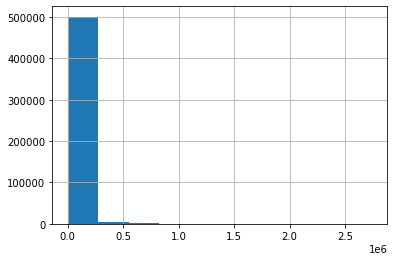

In [159]:
access_cities_results.d_5.hist()

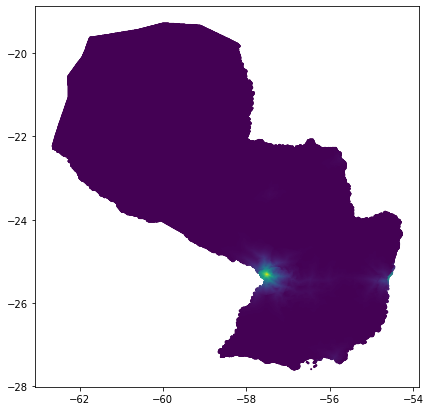

In [160]:
access_cities_results.plot(column='d_5', figsize=(7,7), markersize=1)

In [164]:
for d in range(5,10):
    print(f'writing {d}')
    aggregator.rasterize_gdf(access_cities_results, f'd_{d}', template=raster_path, outFile=os.path.join(output_path,f"access_cities_d{d}.tif"))

writing 5
writing 6
writing 7
writing 8
writing 9


### Make rasters of min travel time to each dest

In [88]:
sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

In [90]:
output_path = os.path.join(out_folder, "out", "travel_distance")
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [91]:
origins_join2['city']

,0,1,2,3,4,5,6,7
pointid,,,,,,,,
1,975.248745,762.069413,1000.155659,1045.081813,886.179361,1183.911057,1015.448782,1230.213784
2,975.909325,762.729993,1000.816239,1045.742393,886.839941,1184.571636,1016.109362,1230.874364
3,976.574394,763.395062,1001.481308,1046.407462,887.505010,1185.236706,1016.774431,1231.539433
4,977.243831,764.064499,1002.150745,1047.076900,888.174447,1185.906143,1017.443868,1232.208870
5,977.917519,764.738187,1002.824433,1047.750587,888.848135,1186.579831,1018.117556,1232.882558
...,...,...,...,...,...,...,...,...
508180,747.201911,700.946837,356.609246,383.366084,338.730802,382.525304,316.593505,115.149040
508181,746.451992,700.196919,355.859328,382.616166,337.980883,381.775386,315.843587,114.399122
508182,745.715997,699.460924,355.123333,381.880171,337.244889,381.039391,315.107592,113.663127


In [92]:
city_min = pd.DataFrame(origins_join2['city'].min(axis=1), columns=["tt_city"])
ports_min = pd.DataFrame(origins_join2['port'].min(axis=1), columns=["tt_port"])
airports_min = pd.DataFrame(origins_join2['airport'].min(axis=1), columns=["tt_airport"])
borders_min = pd.DataFrame(origins_join2['border'].min(axis=1), columns=["tt_border"])

In [93]:
capital_tt = origins_join2['city'].loc[:,[4]].rename(columns={4:'tt_capital'})

In [94]:
origins_tt = origins_snapped.join([city_min, ports_min, airports_min, borders_min, capital_tt])
# origins_tt = origins_snapped.join([city_min, ports_min, airports_min, borders_min])

In [95]:
sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator

In [96]:
output_path

'/home/wb514197/data/INFRA_SAP/PRY/out/travel_distance'

In [97]:
aggregator.rasterize_gdf(origins_tt, 'tt_city', raster_path, os.path.join(output_path,f"cities_min_dist.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_port', raster_path, os.path.join(output_path,f"port_min_dist.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_airport', raster_path, os.path.join(output_path,f"airport_min_dist.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_border', raster_path, os.path.join(output_path,f"borders_min_dist.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_capital', raster_path, os.path.join(output_path,f"capital_dist.tif"))